In [2]:
import numpy as np
import glob
import json
import os
from PIL import Image

import matplotlib.pyplot as plt

from donkeycar.util.data import linear_bin
from donkeycar.parts.keras import default_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

using donkey v2.5.1 ...


In [15]:
%%bash
pip install matplotlib

Looking in indexes: https://rec-nexus.dmp.y-track.com/repository/pypi-all/simple


In [3]:
train_tub_42 = '/home/projects/ironcar-dev/tubs/tub_20181113_42_evening/'
train_tub_5eme = '/home/projects/ironcar-dev/tubs/tub_20181122_ysance_noon/'
val_tub_race = '/home/projects/ironcar-dev/tubs/tub_20181124_morning_lesquare_horaire/'

img_example = '/home/projects/ironcar-dev/tubs/tub_20181124_morning_lesquare_antihoraire/291_cam-image_array_.jpg'
json_exple = '/home/projects/ironcar-dev/tubs/tub_20181124_morning_lesquare_antihoraire/record_291.json'

In [4]:
def convert_angle_to_categorical(value):
    res = []

    for n in value:
        res.append(linear_bin(n))
    
    return np.asarray(res)

In [5]:
def tub_to_array(tub_path, n_first_files=None):
    """
    Return dict of Numpy arrays containing pixel images and associated values of angle and throttle from a tub path

    tub_path: str
        path of tub to convert
    n_first_files: int
        
    """
    pics_list = glob.glob(tub_path + '/*.jpg')
    records_list = glob.glob(tub_path + "/record_*.json")
    
    pics_list.sort(key=lambda x: int(os.path.basename(x).split('_')[0]))
    records_list.sort(key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
    
    pics_list = pics_list[:n_first_files]
    records_list = records_list[:n_first_files]
    
    meta_path = tub_path + "/meta.json"

    x = np.array([np.array(Image.open(fname)) for fname in pics_list])
    y_angle = []
    y_throttle = []
    for file in records_list:
        with open(file, 'r') as f:
            record = json.load(f)
            y_angle.append(record['user/angle'])
            y_throttle.append(record['user/throttle'])
    
    y = {'angle': np.asarray(y_angle), 
         'throttle': np.asarray(y_throttle)}
    
    return x, y

In [6]:
# train validation split

#x_train_42, y_train_42 = tub_to_array(train_tub_42)
x_train_5eme, y_train_5eme = tub_to_array(train_tub_5eme)
y_train_5eme['angle_categorical'] = convert_angle_to_categorical(y_train_5eme['angle']) 

x_val, y_val = tub_to_array(val_tub_race, n_first_files=500)
y_val['angle_categorical'] = convert_angle_to_categorical(y_val['angle'])


In [7]:
# fit model

epochs=100
steps=100
verbose=1
min_delta=.0005
patience=5
use_early_stop=True
saved_model_path = '/home/projects/ironcar-dev/test_models'


model = default_categorical()

# checkpoint to save model after each epoch
save_best = ModelCheckpoint(saved_model_path,
                            monitor='val_loss',
                            verbose=verbose,
                            save_best_only=True,
                            mode='min')

# stop training if the validation error stops improving.
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=min_delta,
                           patience=patience,
                           verbose=verbose,
                           mode='auto')

callbacks_list = [save_best]

if use_early_stop:
    callbacks_list.append(early_stop)

model.summary()
    
# fit from numpy array
# hist = model.fit(x=x_train_5eme,
#                 y=[y_train_5eme['angle_categorical'], y_train_5eme['throttle']],
#                 steps_per_epoch=steps,
#                 epochs=epochs,
#                 verbose=1,
#                 validation_data=(x_val, [y_val['angle_categorical'], y_val['throttle']]),
#                 callbacks=callbacks_list,
#                 validation_steps=200/8)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 120, 160, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 58, 78, 24)   1824        img_in[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 27, 37, 32)   19232       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 12, 17, 64)   51264       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

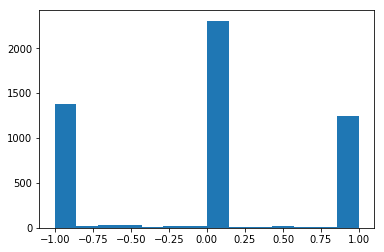

In [92]:
# histogram of Y values

y_angle = y_train_5eme[0]

plt.hist(y_angle, bins='auto')
plt.show()

array([0., 0., 0., ..., 1., 1., 1.])

Structure:
- import data
- train (3 tubs) / test (1 different tub) split
- apply data augmentations
- train + validate

Interface
testor.benchmark([['processing1', 'processing2'], 
                  ['processing4', 'processing2', 'processing5']])